<a href="https://colab.research.google.com/github/ethan-yoo/2022_AIFFEL/blob/main/E11_Transformer_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E11. 트랜스포머를 활용한 한글 챗봇 만들기

학습에 사용할 데이터는 해당 [링크](https://github.com/songys/Chatbot_data)에서 가져옵니다.

**INDEX**

**0. 사용할 모듈 가져오기**

**1. 데이터 전처리하기**

1-1. 문장기호 처리 & 데이터셋 구성

1-2. SubTokenizer 사용

1-3. Word Encoding & Padding

1-4. 교사 강요

**2. 모델 정의 (트랜스포머)**

2-1. 포지셔널 인코딩

2-2. Scaled dot attention

2-3. 멀티 헤드 어텐션

2-4. 마스킹

2-5. 인코더

2-6. 디코더

2-7. 트랜스포머

**3. 모델 생성**

**4. 모델 훈련**

**5. 챗봇 테스트**

**6. 회고**




---

# **0. 사용할 모듈 가져오기**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

print('Done!')

Done!


In [2]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


---

# **1. 데이터 전처리하기**



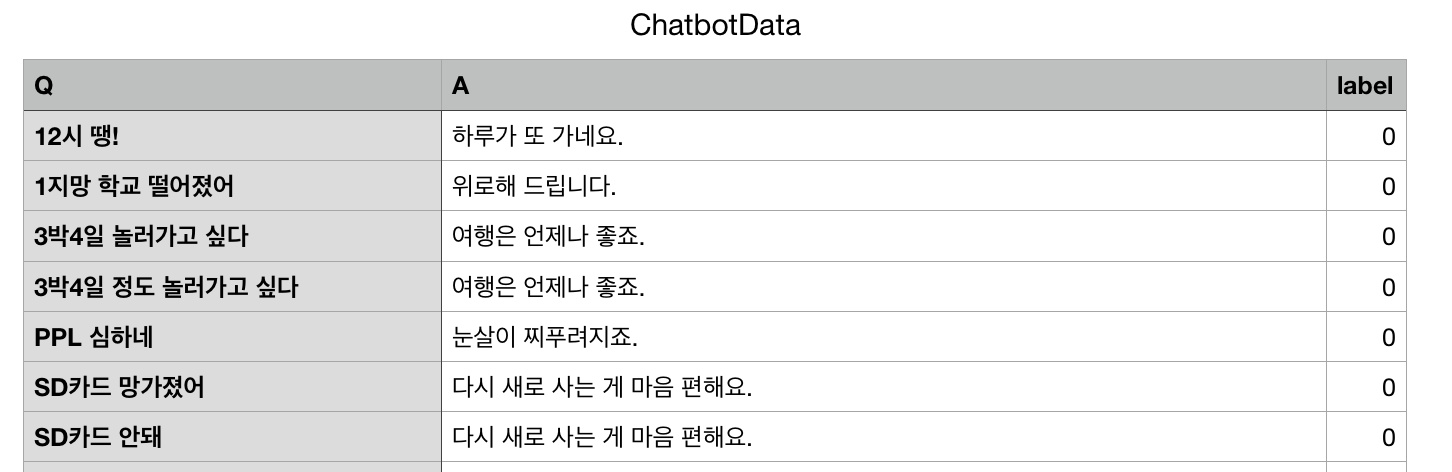

위 이미지를 기반으로 받아온 데이터를 전처리하겠습니다.

먼저 raw data를 살펴보죠.

In [3]:
raw_data = pd.read_csv('/content/mydrive/MyDrive/AIFFEL/E11/ChatbotData.csv')

print('Done!')

Done!


In [4]:
raw_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


위에서 살펴본 안내 그림과 동일합니다. 결측치도 없군요.

Q컬럼과 A컬럼을 각각 질문/답변 컬럼으로 삼아 데이터셋을 구성하고, 각 데이터별로 구두점을 제거하겠습니다.

---

## **1-1. 문장기호 처리 & 데이터셋 구성**

데이터셋 11838개를 모두 사용할 겁니다.

먼저 문장기호들을 제외한 나머지 문장을 다듬어 줍니다.

In [6]:
# 전처리 함수 생성
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # e.g) "I am a student." => "I am a student ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, 한글, 숫자, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
  sentence = re.sub(r"[^a-zA-Z?.!,가-힣0-9]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

print('Done!')

Done!


In [7]:
# 데이터셋 전부 사용
copy = raw_data.copy()

for i in range(len(copy)):
    copy['Q'][i] = preprocess_sentence(copy['Q'][i])
    copy['A'][i] = preprocess_sentence(copy['A'][i])

copy.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Q,A,label
0,12시 땡 !,하루가 또 가네요 .,0
1,1지망 학교 떨어졌어,위로해 드립니다 .,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0
4,ppl 심하네,눈살이 찌푸려지죠 .,0


In [8]:
# question set
questions = copy['Q']

# answer set
answers = copy['A']

print('Done!')

Done!


---

## **1-2. SubTokenizer 사용**

In [9]:
# subwordtokenizer
# subword를 토큰화하면 형태소 분석하는 것과 비슷
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=8000)

print('Done!')

Done!


In [10]:
# start & end token 인덱스 부여
# 기존 단어장 번호와 겹치지 않게 +1
start_token, end_token = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('Start Token: {}'.format([tokenizer.vocab_size]))
print('End Token: {}'.format([tokenizer.vocab_size + 1]))

Start Token: [8357]
End Token: [8358]


In [11]:
# 단어장 크기를 +2 합니다. (start, end token)
VOCAB_SIZE = tokenizer.vocab_size + 2
print('단어장 크기: {}'.format(VOCAB_SIZE))

단어장 크기: 8359


뭔가 이상한 점이 있지 않나요?

분명 위에서 target_vocab_size = 8000으로 지정했는데, 실제 단어장 크기는 8359가 되었습니다.

> **why tensorflow target vocab_size create approximate number of vocab? |** [링크](https://stackoverflow.com/questions/56308612/what-exactly-does-target-vocab-size-mean-in-the-method-tfds-features-text-subwor)

위 링크에 따르면 지정된 크기보다 input corpus의 단어 숫자가 많을 경우, 해당 단어들을 한 글자씩 인코딩한다고 합니다.

예를 들어서 "I am a cat"을 입력으로 주고 단어장 크기를 3으로 지정하면 최종 단어장 크기는 6이 됩니다.

('I', 'am', 'a' 까지는 단어장에 한 토큰으로 저장되고 남은 cat을 'c', 'a', 't'로 나누어 저장함)



---

## **1-3. Word Encoding & Padding**

적절한 문장 길이를 확인해보겠습니다.

In [12]:
# 문장 길이 확인
question_len = [len(cor.split()) for cor in questions]
answer_len = [len(cor.split()) for cor in answers]

# questions
print('최대 질문 길이: {}'.format(np.max(question_len)))
print('평균 질문 길이: {}'.format(round(np.mean(question_len), 2)))

# answers
print('최대 답변 길이: {}'.format(np.max(answer_len)))
print('평균 답변 길이: {}'.format(round(np.mean(answer_len), 2)))

최대 질문 길이: 16
평균 질문 길이: 3.94
최대 답변 길이: 24
평균 답변 길이: 4.72


최대 길이 25 정도로 잡으면 될 것 같습니다.

In [13]:
MAX_LENGTH = 25

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = start_token + tokenizer.encode(sentence1) + end_token
        sentence2 = start_token + tokenizer.encode(sentence2) + end_token

        # 최대 길이 25 이하인 경우에는 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 25에 맞춰 데이터셋 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

print('Done!')

Done!


In [14]:
# 단어장 크기, 샘플 개수 확인
questions, answers = tokenize_and_filter(questions, answers)

print('단어장 크기: {}'.format(VOCAB_SIZE))
print('필터링 후 질문 샘플 수: {}'.format(len(questions)))
print('필터링 후 단어 샘플 수: {}'.format(len(answers)))

단어장 크기: 8359
필터링 후 질문 샘플 수: 11817
필터링 후 단어 샘플 수: 11817


필터링 전 질답 샘플 수가 11823이었으니 총 6개 데이터가 빠졌군요.

---

## **1-4. 교사 강요 (Teacher Forcing)**

In [15]:
batch_size = 64
buffer_size = 20000

# 디코더는 이전 target을 다음 input으로 사용
# 따라서 outputs에서 start_token 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print('Done!')

Done!


---

# **2. 모델 정의 (트랜스포머)**

## **2-1. 포지셔널 인코딩**

In [16]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("Done!")

Done!


## **2-2. Scaled dot attention**

In [17]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print('Done!')

Done!


## **2-3. 멀티 헤드 어텐션**

In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

print("Done!")

Done!


## **2-4. 마스킹**

In [19]:
# 패딩 마스킹
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

print('Done!')

Done!


In [20]:
# Look ahead masking
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1,0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

print('Done!')

Done!


---

## **2-5. 인코더**

In [21]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
print("Done!")

Done!


In [22]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
print("Done!")

Done!


---

## **2-6. 디코더**

In [23]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  
print("Done!")

Done!


In [24]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  
print("Done!")

Done!


---

## **2-7. 트랜스포머**

In [25]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

print('Done!')

Done!


---

# **3. 모델 생성**

In [26]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3194112     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [27]:
# loss 함수 생성
# 패딩 고려
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

print("Done!")

Done!


In [28]:
# 커스텀 학습률 스케줄러를 활용한 아담 옵티마이저 사용

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

print("Done!")

Done!


Text(0.5, 0, 'Train Step')

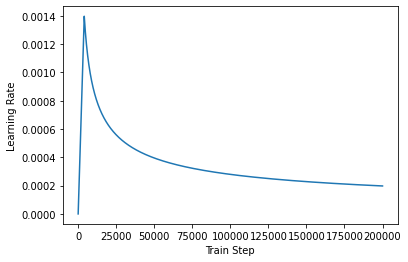

In [29]:
# 테스트 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [30]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH- 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

print('Done!')

Done!


---

# **4. 모델 훈련**

In [31]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 19s 56ms/step - loss: 2.3583 - accuracy: 0.0481
Epoch 2/50
185/185 [==============================] - 10s 53ms/step - loss: 1.9119 - accuracy: 0.0804
Epoch 3/50
185/185 [==============================] - 10s 55ms/step - loss: 1.6306 - accuracy: 0.0823
Epoch 4/50
185/185 [==============================] - 10s 52ms/step - loss: 1.5071 - accuracy: 0.0883
Epoch 5/50
185/185 [==============================] - 10s 51ms/step - loss: 1.4134 - accuracy: 0.0936
Epoch 6/50
185/185 [==============================] - 10s 51ms/step - loss: 1.3177 - accuracy: 0.1006
Epoch 7/50
185/185 [==============================] - 10s 54ms/step - loss: 1.2101 - accuracy: 0.1101
Epoch 8/50
185/185 [==============================] - 9s 51ms/step - loss: 1.0909 - accuracy: 0.1226
Epoch 9/50
185/185 [==============================] - 9s 51ms/step - loss: 0.9646 - accuracy: 0.1365
Epoch 10/50
185/185 [==============================] - 9s 51ms/step - loss: 0.8325 -

---

# **5. 챗봇 테스트**

새로운 입력 문장에 대해서는 훈련때와 동일한 전처리를 거칩니다.

1) 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가합니다.

2) 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.

3) 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.

4) 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.

5) END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [32]:
# 예측 처리 함수 생성
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      start_token + tokenizer.encode(sentence) + end_token, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(start_token, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, end_token[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

print("Done!")

Done!


In [33]:
# 챗봇 대답 출력기
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

print("Done!")

Done!


이제 고대하던 질문 시간입니다.

데이터 출처에서는 위로형 챗봇 데이터에 가깝다고 말하고 있습니다.

따라서 위로를 요구하는 질문을 포함해 여러가지를 테스트해보겠습니다.

In [34]:
sentence_generation('나 이혼했어')

입력 : 나 이혼했어
출력 : 쉽지 않은 결정이죠 .


'쉽지 않은 결정이죠 .'

In [35]:
sentence_generation('우울해')

입력 : 우울해
출력 : 많이 힘들었죠 .


'많이 힘들었죠 .'

In [36]:
sentence_generation('입맛도 없고...')

입력 : 입맛도 없고...
출력 : 잘 더 같습니다 .


'잘 더 같습니다 .'

위로하는 말은 나름 그럴듯하게 뽑아내는 것 같습니다.

입맛이 없다는 말만 빼고요.

다른 인풋도 넣어보겠습니다.

In [37]:
sentence_generation('배고파')

입력 : 배고파
출력 : 얼른 맛난 음식 드세요 .


'얼른 맛난 음식 드세요 .'

In [38]:
sentence_generation('심심해')

입력 : 심심해
출력 : 친구들과 연락해보세요 .


'친구들과 연락해보세요 .'

In [39]:
sentence_generation('나 결혼해')

입력 : 나 결혼해
출력 : 기억들이 많겠네요 .


'기억들이 많겠네요 .'

위로 외에도 나름 그럴싸한 대답들을 잘 뽑아냅니다.

그래도 예전 인공지능 작사가에 비하면 장족의 발전입니다.

In [40]:
sentence_generation('나랑 게임할래?')

입력 : 나랑 게임할래?
출력 : 제가 좀 더 떨리네요 .


'제가 좀 더 떨리네요 .'

In [41]:
sentence_generation('게임할래?')

입력 : 게임할래?
출력 : 제가 좀 더 떨리네요 .


'제가 좀 더 떨리네요 .'

In [42]:
sentence_generation('놀래?')

입력 : 놀래?
출력 : 저랑 놀아요 .


'저랑 놀아요 .'

In [43]:
sentence_generation('나랑 놀래?')

입력 : 나랑 놀래?
출력 : 저랑 놀아요 .


'저랑 놀아요 .'

질문에도 잘 대답하는 편입니다.

In [44]:
sentence_generation('어떡하면 좋을까?')

입력 : 어떡하면 좋을까?
출력 : 무슨 일인지 말해주세요 .


'무슨 일인지 말해주세요 .'

In [45]:
sentence_generation('어떡해야 할까?')

입력 : 어떡해야 할까?
출력 : 제가 할 수 있는 건 도와드릴게요 .


'제가 할 수 있는 건 도와드릴게요 .'

상당히 사람같은 대답을 하는 것을 볼 수 있습니다. 

흠, 혹시 이모티콘도 읽을 수 있을까요?

In [46]:
sentence_generation('^^')

입력 : ^^
출력 : 많이 힘들죠 .


'많이 힘들죠 .'

In [47]:
sentence_generation('^^;')

입력 : ^^;
출력 : 많이 힘들죠 .


'많이 힘들죠 .'

In [48]:
sentence_generation('ㅠㅠ')

입력 : ㅠㅠ
출력 : 많이 힘들죠 .


'많이 힘들죠 .'

In [51]:
sentence_generation('TT')

입력 : TT
출력 : 자신을 위한 선택이길 바랄게요 .


'자신을 위한 선택이길 바랄게요 .'

눈치채셨겠지만 특수문자를 위에서 처리했기 때문에 이모티콘을 못 읽는 것을 볼 수 있습니다.

위로를 테마로 한 챗봇 데이터이다 보니 뭔 말인지 모르겠으면 일단 '많이 힘들죠'를 출력하는 것 같네요.

---

# **6. 회고**

- 트랜스포머 모델은 사실 밑시딥 풀잎스쿨에서 다룬 부분이라 나름 기대를 했습니다. 얼마나 이해할 수 있을까~ 하고... 근데 구현 코드가 책이랑 달라서 조금 헤맸습니다.

- 과거 인공지능 작사가의 성능을 생각하면 트랜스포머는 소량의 데이터만으로 압도적인 성능을 발휘하는 게 맞는 것 같습니다. 학습한 데이터를 벗어나지 못한다는 한계야 뭐 머신러닝이 다 그런것이고.... 대신 자기가 학습한 데이터 내에서는 정말 확연하게 성능 향상이 느껴졌습니다.

- 찾아보니까 SentenceBERT를 활용해서 코드 47줄만으로 챗봇 만드는 유튜브 영상도 있던데 학습 데이터를 좋은 걸 쓰더라고요. 역시 데이터가 머신러닝의 95% 이상을 차지하는 게 맞는 것 같습니다.

**끝!**